In [1]:
import sys
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType,VarcharType,TimestampType,StringType

In [2]:
spark = SparkSession.builder.appName("CreditCardSystemApp").master("local[*]").getOrCreate()

In [3]:
data_loan_data=spark.read.format("jdbc") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("dbtable","creditcard_capstone.CDW_SAPP_loan_application" ) \
        .option("user", "root") \
        .option("password", "password")\
        .load()

In [4]:
data_loan_data.createOrReplaceTempView("Loan_table")

In [5]:
df_approved_perc=spark.sql("select count(*) as count,count(*)*100/(select count(*) from Loan_table where Application_Status='Y') \
          as Approved_Percentage from Loan_table where Self_Employed='Yes'")

In [6]:
df_approved_perc.show()

+-----+-------------------+
|count|Approved_Percentage|
+-----+-------------------+
|   70| 20.172910662824208|
+-----+-------------------+



In [7]:
df_loan_table=spark.sql("select * from Loan_table")
df_approved_perc=df_loan_table.toPandas()

In [8]:
df_approved_perc

,Application_ID,Application_Status,Credit_History,Dependents,Education,Gender,Income,Married,Property_Area,Self_Employed
0,LP001002,Y,1,0,Graduate,Male,medium,No,Urban,No
1,LP001003,N,1,1,Graduate,Male,medium,Yes,Rural,No
2,LP001005,Y,1,0,Graduate,Male,low,Yes,Urban,Yes
3,LP001006,Y,1,0,Not Graduate,Male,low,Yes,Urban,No
4,LP001008,Y,1,0,Graduate,Male,medium,No,Urban,No
...,...,...,...,...,...,...,...,...,...,...
506,LP002978,Y,1,0,Graduate,Female,low,No,Rural,No
507,LP002979,Y,1,3+,Graduate,Male,medium,Yes,Rural,No
508,LP002983,Y,1,1,Graduate,Male,medium,Yes,Urban,No
509,LP002984,Y,1,2,Graduate,Male,medium,Yes,Urban,No


In [9]:
df=df_approved_perc[['Application_Status','Self_Employed']].value_counts()

<Axes: ylabel='count'>

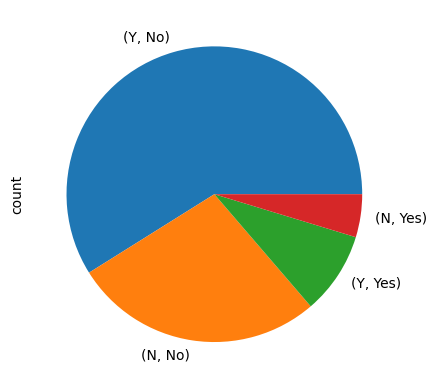

In [10]:
df.plot.pie()

In [11]:
df2=df_approved_perc[['Married','Application_Status','Gender']].value_counts()
df2

Married  Application_Status  Gender
Yes      Y                   Male      219
         N                   Male       87
No       Y                   Male       71
         N                   Male       43
         Y                   Female     40
         N                   Female     26
Yes      Y                   Female     17
         N                   Female      8
Name: count, dtype: int64

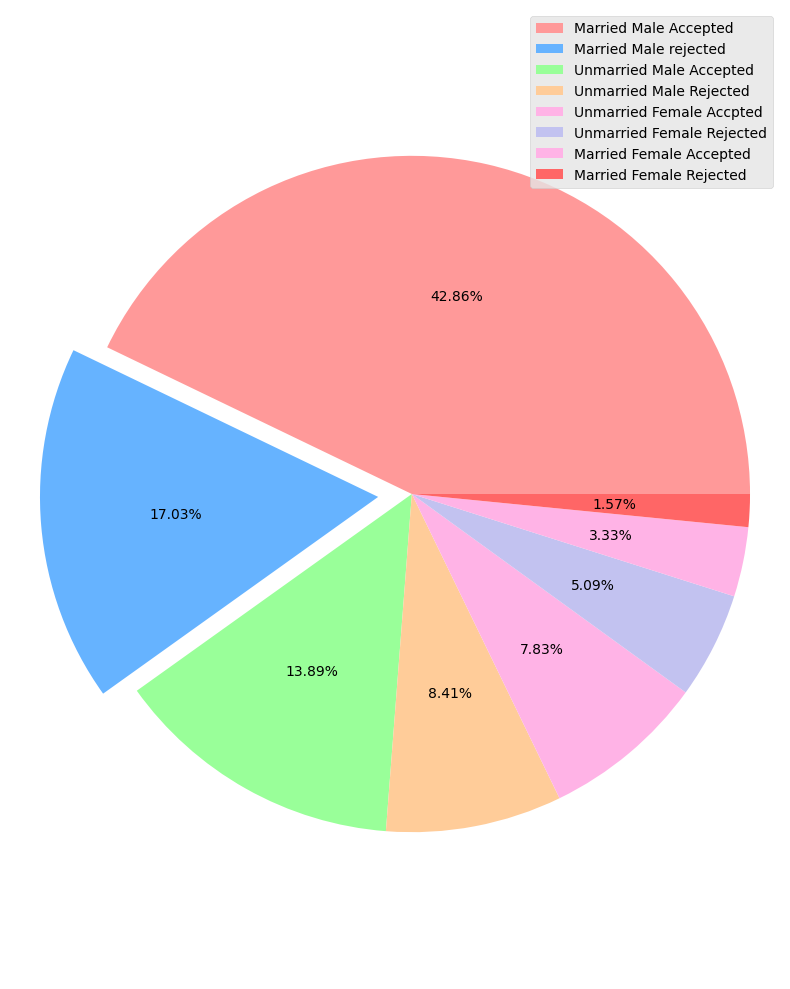

In [12]:
plt.rcParams["figure.figsize"] = [8, 10]
plt.rcParams["figure.autolayout"] = True
explode=(0,0.1,0,0,0,0,0,0)
plt.style.use('ggplot')
labels=['Married Male Accepted','Married Male rejected','Unmarried Male Accepted','Unmarried Male Rejected','Unmarried Female Accpted','Unmarried Female Rejected','Married Female Accepted','Married Female Rejected']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ffb3e6', '#c2c2f0','#ffb3e6','#ff6666']
plt.pie(df2,autopct='%.2f%%',explode=explode,startangle=0,colors=colors)
plt.axis('equal')

plt.legend(labels,loc='upper right')
plt.show()

Find and plot the top three months with the largest transaction data

In [13]:

data_transaction_data=spark.read.format("jdbc") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("dbtable","creditcard_capstone.CDW_SAPP_credit_card" ) \
        .option("user", "root") \
        .option("password", "password")\
        .load()

In [14]:
data_transaction_data.dtypes

[('BRANCH_CODE', 'int'),
 ('CUST_SSN', 'int'),
 ('TRANSACTION_ID', 'int'),
 ('TRANSACTION_TYPE', 'string'),
 ('TRANSACTION_VALUE', 'double'),
 ('CUST_CC_NO', 'string'),
 ('TIMEID', 'timestamp')]

In [15]:
data_transaction_data.createOrReplaceTempView("Transaction_table")

In [16]:
df_transaction=spark.sql("select * from Transaction_table")

In [17]:
df_transaction=df_transaction.withColumn('TIMEID', func.to_date(df_transaction["TIMEID"]))

In [18]:
df_transaction.show()

+-----------+---------+--------------+----------------+-----------------+----------------+----------+
|BRANCH_CODE| CUST_SSN|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|      CUST_CC_NO|    TIMEID|
+-----------+---------+--------------+----------------+-----------------+----------------+----------+
|        156|123455692|         22562|         Grocery|            91.08|4210653312478046|2018-08-13|
|        180|123451310|         45069|           Bills|            77.79|4210653342242023|2018-03-15|
|        114|123459988|             1|       Education|             78.9|4210653349028689|2018-02-14|
|        114|123455692|         22563|           Bills|             22.2|4210653312478046|2018-06-26|
|        107|123451310|         45070|      Healthcare|            20.47|4210653342242023|2018-04-19|
|         35|123459988|             2|   Entertainment|            14.24|4210653349028689|2018-03-20|
|         47|123455692|         22564|         Grocery|            77.54|421065331

In [19]:
df_transaction=df_transaction.withColumn('TIMEID', func.to_date(df_transaction["TIMEID"]))

In [20]:
top3transaction=spark.sql("select MONTH(TIMEID) AS month,count(*) as count from Transaction_table  group by month(TIMEID) order by 2 DESC limit 3")

In [21]:
top3transaction.show()

+-----+-----+
|month|count|
+-----+-----+
|    2| 3959|
|    5| 3946|
|   10| 3946|
+-----+-----+



In [22]:
top3transaction=top3transaction.toPandas()

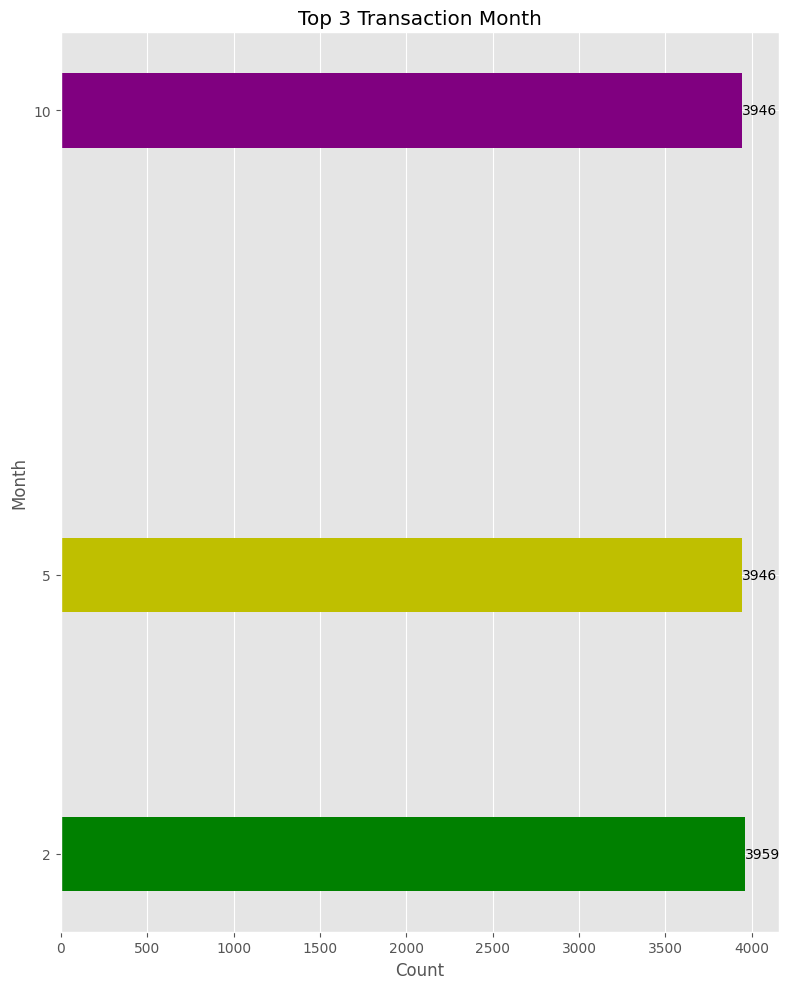

In [23]:
fig, ax = plt.subplots()
colors=['green','y','purple']
g=ax.barh(top3transaction['month'], top3transaction['count'],color=colors)
ax.set_xlabel("Count")
ax.set_ylabel("Month")
ax.bar_label(g, label_type="edge") # This provides the labelling, this only available at higher version. You can do pip install -U matplotlib

plt.title("Top 3 Transaction Month")

plt.yticks(top3transaction['month'])
plt.tight_layout()
plt.show()

In [26]:
tophealthtransaction=spark.sql("select BRANCH_CODE ,round(sum(TRANSACTION_VALUE)) FROM Transaction_table \
                               where TRANSACTION_TYPE='Healthcare' group by BRANCH_CODE,TRANSACTION_TYPE order by 2 desc limit 10;")

In [28]:
tophealthtransaction.show()

+-----------+--------------------------------+
|BRANCH_CODE|round(sum(TRANSACTION_VALUE), 0)|
+-----------+--------------------------------+
|         25|                          4370.0|
|         60|                          4072.0|
|         83|                          4003.0|
|         36|                          3824.0|
|        111|                          3720.0|
|         90|                          3697.0|
|         21|                          3652.0|
|        109|                          3604.0|
|         42|                          3603.0|
|         70|                          3594.0|
+-----------+--------------------------------+

